# segy reader

### imports

In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
from PIL import Image
from obspy.io.segy.segy import _read_segy
import matplotlib.pyplot as plt
%matplotlib inline

### reader class

In [2]:
class SegyReader(object):

    def __init__(self, path, labels_path, batch_size, file_extension=".sgy", max_size=-1):
        """
        :param path:
        :param labels_path:
        :param batch_size:
        :param file_extension:
        :param max_size:
        """
        self._idx = None
        self.path = path
        self.labels_path = labels_path
        self._paths = list()
        self._labels = list()
        self._file_extension = file_extension
        self._max_size = max_size
        self._batch_size = batch_size
        self.load_data()

    def load_data(self):
        with open(self.labels_path, 'r') as f:
            for row in f:
                name, label = row.split(",")
                label = label.lower().strip()
                name = name.strip().replace(".png", ".segy")
                self._paths.append(os.path.join(self.path, name))
                if label == "good":
                    self._labels.append(0)
                elif label == "bad":
                    self._labels.append(1)
                elif label == "ugly":
                    self._labels.append(2)
                else:
                    raise ValueError("Label not recognized. Found in data: '{}'".format(label))
                if 0 < self._max_size == len(self._paths):
                    break

        self._paths = np.asarray(self._paths)
        self._labels = np.asarray(self._labels)

    def load_from_dir(self):
        self._paths = list()
        self._labels = list()
        for root, _, files in os.walk(self.path):
            for file in files:
                if not file.endswith(self._file_extension):
                    continue
                file_path = os.path.join(root, file)
                self._paths.append(file_path)
                self._labels.append(0)

                if 0 < self._max_size == len(self._paths):
                    break
        self._paths = np.asarray(self._paths)
        self._labels = np.asarray(self._labels)

    def __len__(self):
        return len(self._paths)

    def __getitem__(self, item):
        if isinstance(item, int):
            return self._paths[item], self._labels[item]

        elif isinstance(item, slice):
            return self._paths[item], self._labels[item]

    def __iter__(self):
        """
        Iterator initializer.
        """
        self._idx = 0
        return self

    def __next__(self):
        """
        Returns the iterator's next element.
        """
        mod_batch = len(self) % self._batch_size
        if self._idx >= (len(self) - mod_batch):

            perm = np.random.permutation(len(self._paths))
            self._paths = self._paths[perm]
            self._labels = self._labels[perm]

            raise StopIteration()

        x = self.load_img(self._paths[self._idx])
        y = self._labels[self._idx]
        # index sum
        self._idx += 1
        return x, y

    def make_dataset(self):
        """
        Returns a tensorflow Dataset created from this current iterator.
        :return: a `tf.data.Dataset`.
        """
        batch_size = self._batch_size
        prefetch_buffer = 10
        dataset = tf.data.Dataset.from_generator(
            generator=lambda: iter(self),
            output_types=(tf.float32, tf.int32),
            # output_shapes=self._inputs_config["output_shapes"]
        )
        dataset = dataset.batch(batch_size)
        return dataset.prefetch(buffer_size=prefetch_buffer)

    def load_img(self, img_path):
        """
        reads and normalize a seismogram from the given segy file.
        :param img_path: a path to the segy file.
        :return: seismogram image as numpy array normalized between 0-1.
        """
        segy = _read_segy(img_path)
        _traces = list()
        for trace in segy.traces:
            _traces.append(trace.data)
        x = np.asarray(_traces, dtype=np.float32)
        std = x.std()
        x -= x.mean()
        x /= std
        x *= 0.1
        x += .5
        x = np.clip(x, 0, 1)

        return x.T

## Using reader

In [3]:
reader = SegyReader(
    path="../data/sgy/",
    labels_path="datasets/train_labels.txt",
    batch_size=10
)

print("len_reader:", len(reader))

for i in range(5):
    x_path, y = reader[i]
    print(x_path, y)

len_reader: 5223
../data/sgy/sismoMod_Exp_00002864.segy 1
../data/sgy/sismoMod_Exp_00000097.segy 1
../data/sgy/sismoMod_Exp_00002657.segy 1
../data/sgy/sismoMod_Exp_00003978.segy 2
../data/sgy/sismoMod_Exp_00003005.segy 1


In [4]:
reader = SegyReader(
    path="../data/sgy/",
    labels_path="datasets/train_labels.txt",
    batch_size=10
)

# este método não está preechendo as labels.
# crado apenas para exemplificar uso da classe
reader.load_from_dir()
print("len_reader:", len(reader))
for i in range(4):
    x_path, y = reader[i]
    print(x_path, y)

len_reader: 4
../data/sgy/sismoMod_Exp_00003885.sgy 0
../data/sgy/sismoMod_Exp_00000113.sgy 0
../data/sgy/SHT_RAW_H-Gt_P_UP_L2488P2098.P26773_Smallpart.sgy 0
../data/sgy/sismoMod_Exp_0111.sgy 0


### ploting image

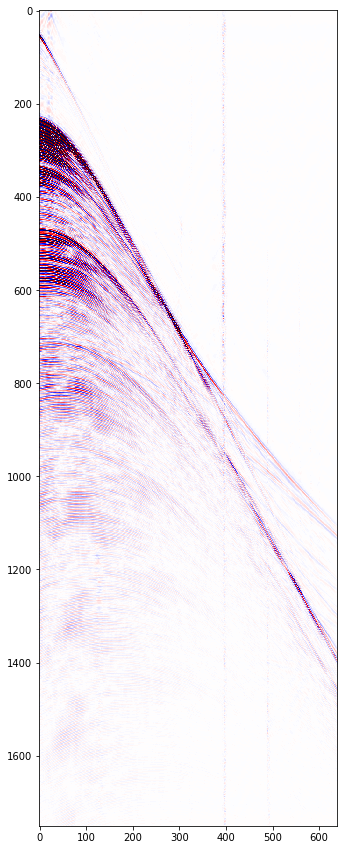

In [5]:
p, y = reader[0]
x = reader.load_img(p)
fig, ax1 = plt.subplots(1, 1, figsize=(15, 15))
ax1.imshow(x, cmap="seismic")

### usando como tf dataset

In [6]:
reader = SegyReader(
    path="../data/sgy/",
    labels_path="datasets/train_labels.txt",
    batch_size=1
)
# este método não está preechendo as labels.
# crado apenas para exemplificar uso da classe
reader.load_from_dir()

segy_ds = reader.make_dataset()
segy_ds

W1005 16:15:39.413081 139791474566976 deprecation.py:323] From /home/luis/MyComputer/Projetos/virtual-environments/.virtualenvs/image-transformer/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


<DatasetV1Adapter shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [7]:
tf_iter = segy_ds.make_initializable_iterator()
tf_iter

W1005 16:15:39.448383 139791474566976 deprecation.py:323] From <ipython-input-7-15331bd3a51f>:1: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [8]:
tf_iter_init = tf_iter.make_initializer(segy_ds)
tf_iter_init

W1005 16:15:39.468055 139791474566976 deprecation.py:323] From /home/luis/MyComputer/Projetos/virtual-environments/.virtualenvs/image-transformer/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:348: Iterator.output_types (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
W1005 16:15:39.469765 139791474566976 deprecation.py:323] From /home/luis/MyComputer/Projetos/virtual-environments/.virtualenvs/image-transformer/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:349: Iterator.output_shapes (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
W1005 16:15:39.471403 139791474566976 deprecation.py:323] From /home/luis/MyComputer/Projetos/virtual-environments/.virtualenvs/image-transformer/li

<tf.Operation 'make_initializer' type=MakeIterator>

In [9]:
x, y = tf_iter.get_next()
x, y

(<tf.Tensor 'IteratorGetNext:0' shape=<unknown> dtype=float32>,
 <tf.Tensor 'IteratorGetNext:1' shape=<unknown> dtype=int32>)

x_shape:  (1, 1751, 640)
y_shape: (1,)
x_shape:  (1, 1751, 638)
y_shape: (1,)
x_shape:  (1, 5001, 1000)
y_shape: (1,)
x_shape:  (1, 2001, 321)
y_shape: (1,)


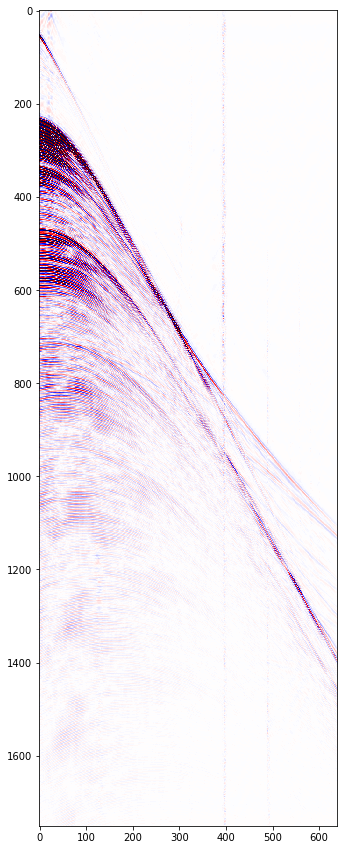

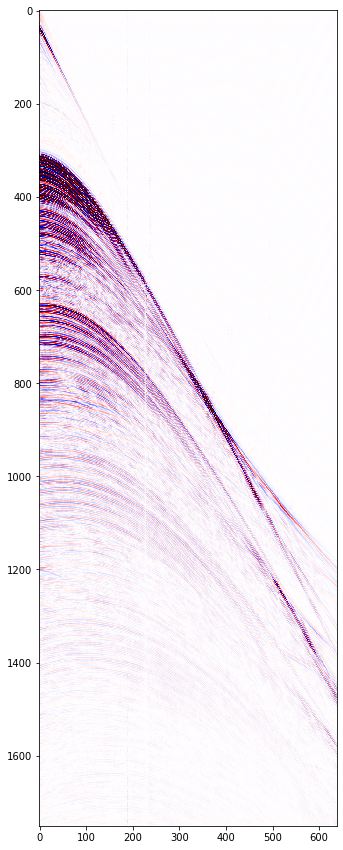

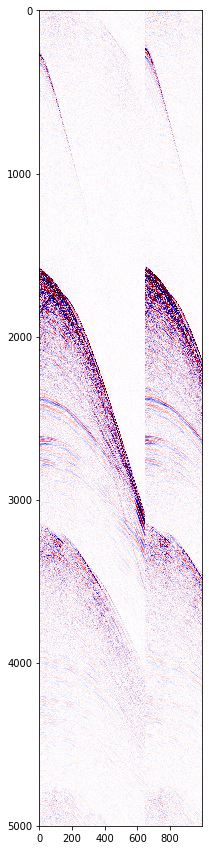

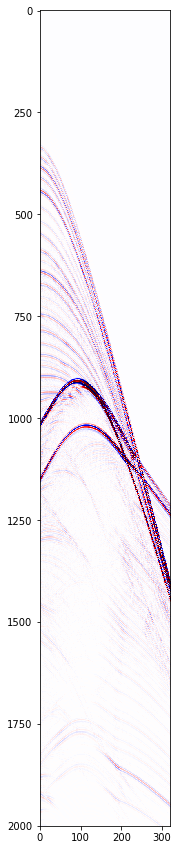

In [10]:
with tf.Session() as sess:
    # inicia o iterator o iterator
    sess.run(tf_iter_init)
    try:
        # itera sobre todas as imagens
        while True:
            outs = sess.run([x, y])
            print("x_shape: ", outs[0].shape)
            print("y_shape:", outs[1].shape)
            fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
            ax1.imshow(outs[0][0], cmap="seismic")
    except tf.errors.OutOfRangeError:
        pass

## Iterando pelo python    

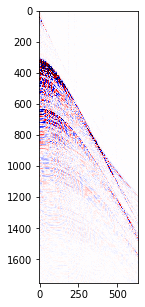

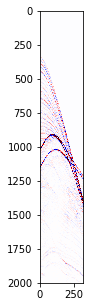

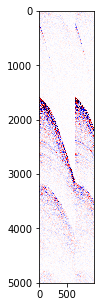

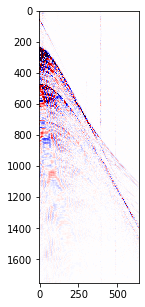

In [12]:
for x, y in reader:
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    ax1.imshow(x, cmap="seismic")